<a href="https://colab.research.google.com/github/ozgesengil/fMRI_Analysis_Scripts/blob/main/Coherence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Coherence Analysis
First the usual definitions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm
from scipy import signal

def hrf_double_gamma(t,n1,n2,lmbd1,lmbd2,t01,t02,a):
  c = (gamma.cdf(t[t.size-1],n1,loc=t01,scale=lmbd1)
        - a * gamma.cdf(t[t.size-1],n2,loc=t02,scale=lmbd2))
  return ( 1/c * (gamma.pdf(t,n1,scale=lmbd1,loc=t01)
                   - a * gamma.pdf(t,n2,scale=lmbd2,loc=t02)))

def hrf_single_gamma(t,n,lmbd,t0):
  return gamma.pdf(t,n,loc=t0,scale=lmbd)

def bold_response(n, h):
  return np.convolve(n,h)

Let's first create two BOLD responses with one slightly shifted with respect to the other

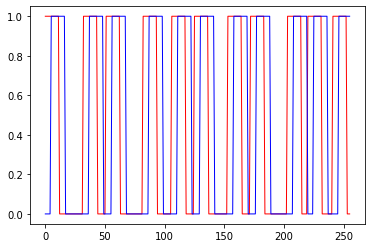

In [ ]:
nTR = 256
eventDuration = 12
initialRest = 0
finalRest = 20
ISImin = 5
ISImax = 20
nShift =  5#@param {type:"integer"}

box1 = np.zeros(nTR)
box2 = np.zeros(nTR)
box1[initialRest:initialRest+eventDuration] = np.ones(eventDuration)
t = initialRest + eventDuration
while t<nTR-finalRest:
    ISI = int(np.rint(np.random.uniform(low = ISImin, high = ISImax)))
    box1[t+ISI:t+ISI+eventDuration] = np.ones(eventDuration)
    t = t + ISI+eventDuration
plt.plot(box1, color='red', linestyle='solid', linewidth=1)
box2[nShift:nTR] = box1[0:nTR-nShift]
plt.plot(box2, color='blue', linestyle='solid', linewidth=1)
plt.show()

Next, let's simulate BOLD response with them using two slightly different HRFs

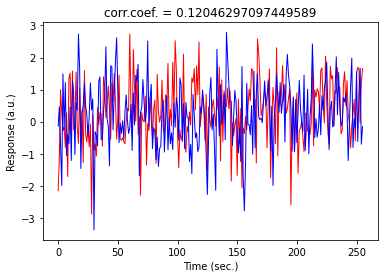

In [ ]:
# two slightly different HRFs
n1 = 4
lmbd1 = 2.0
t01 = 0
n2 = 7
lmbd2 = 2
t02 = 0
a = 0.3
time = np.arange(0,nTR)
bold_double_gamma = hrf_double_gamma(time, n1, n2, lmbd1, lmbd2, t01, t02, a)
t01 = 0
bold_single_gamma = hrf_single_gamma(time, n1, lmbd1, t01)

HRF1 = 'Double-Gamma' #@param ['Single-Gamma','Double-Gamma']
if HRF1 == "Single-Gamma":
  hrf1 = bold_single_gamma
elif HRF1 =="Double-Gamma":
  hrf1 = bold_double_gamma

HRF2 = 'Single-Gamma' #@param ['Single-Gamma','Double-Gamma']
if HRF2 =="Single-Gamma":
  hrf2 = bold_single_gamma
elif HRF2 =="Double-Gamma":
  hrf2 = bold_double_gamma

# corresponding BOLD responses
bold1 = bold_response(box1, hrf1)
bold2 = bold_response(box2, hrf2)

noise_sigma =  1#@param {type:"raw"};
bold1 += norm.rvs(scale = noise_sigma, size=bold1.size)
bold2 += norm.rvs(scale = noise_sigma, size=bold2.size)
bold1 = (bold1 - np.mean(bold1))/np.std(bold1)
bold2 = (bold2 - np.mean(bold2))/np.std(bold2)

# Compute correlation between the BOLDs
correlation = np.corrcoef(bold1,bold2)

plt.plot(time, bold1[0:time.size], color='red', linestyle='solid', linewidth=1)
plt.plot(time, bold2[0:time.size], color='blue', linestyle='solid', linewidth=1)
plt.title('corr.coef. = ' + str(correlation[0][1]))
plt.ylabel('Response (a.u.)')
plt.xlabel('Time (sec.)')
plt.show()

Finally, let's compute the coherence

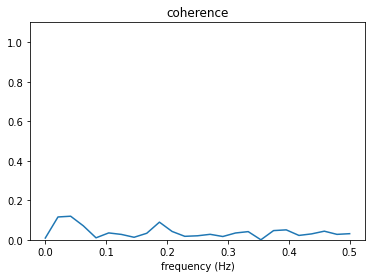

In [ ]:
f, c = signal.coherence(bold1,bold2,fs=1.0,nfft=48,noverlap=24,nperseg=32)
plt.plot(f,c)
plt.ylim(0,1.1)
plt.title('coherence')
plt.xlabel('frequency (Hz)')
plt.show()